### Chest-X-RAY_Pneumonia-Detection dataset
Dataset link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [37]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset, TensorDataset
import numpy as np
import cv2
import matplotlib.pyplot  as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [38]:
# Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [39]:
# Function to load images
def load_images(path_pattern):
    import glob
    images = []
    for filename in glob.glob(path_pattern):
        img = cv2.imread(filename)
        img = cv2.resize(img, (128, 128))
        images.append(img)
    return images

# Load the images
healthy_train = load_images('./chest_xray/train/NORMAL/*.jpeg')
pneumonia_train = load_images('./chest_xray/train/PNEUMONIA/*.jpeg')
healthy_test = load_images('./chest_xray/test/NORMAL/*.jpeg')
pneumonia_test = load_images('./chest_xray/test/PNEUMONIA/*.jpeg')
healthy_val = load_images('./chest_xray/val/NORMAL/*.jpeg')
pneumonia_val = load_images('./chest_xray/val/PNEUMONIA/*.jpeg')

# Convert lists to numpy arrays
healthy = np.array(healthy_train + healthy_test + healthy_val, dtype=np.float32)
print("Healthy", healthy.shape)
pneumonia = np.array(pneumonia_train + pneumonia_test + pneumonia_val, dtype=np.float32)
print("Pneumonia", pneumonia.shape)

# Labels
pneumonia_label = np.ones(pneumonia.shape[0], dtype=np.float32)
healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

num_samples = min(len(pneumonia), len(healthy))
pneumonia_sampled = pneumonia[:num_samples]
healthy_sampled = healthy[:num_samples]

pneumonia_label_sampled = pneumonia_label[:num_samples]
healthy_label_sampled = healthy_label[:num_samples]

# Concatenate sampled images and labels
images = np.concatenate((pneumonia_sampled, healthy_sampled), axis=0)
labels = np.concatenate((pneumonia_label_sampled, healthy_label_sampled))

# # Concatenate images and labels
# images = np.concatenate((pneumonia, healthy), axis=0)
# labels = np.concatenate((pneumonia_label, healthy_label))

# Normalize images
images = images / 255.0

# Convert to PyTorch tensors
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Add channel dimension
images = images.permute(0, 3, 1, 2)

Healthy (1583, 128, 128, 3)
Pneumonia (4273, 128, 128, 3)


In [40]:
# Create TensorDataset
dataset = TensorDataset(images, labels)

In [43]:
# Split dataset into train and validation sets
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [44]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Creating a CNN Model

In [45]:
# Model Architecture with Regularization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [46]:
# Model Initialization
model = CNN()

In [47]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [48]:
# Training and Validation Loop
num_epochs = 5
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.sigmoid(outputs).squeeze() >= 0.5
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    scheduler.step()
    
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            preds = torch.sigmoid(outputs).squeeze() >= 0.5
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss = val_loss / val_size
    val_acc = val_corrects.double() / val_size
    
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

Epoch 0/4
Training Loss: 0.4757 Acc: 0.7580
Validation Loss: 0.1685 Acc: 0.9510
Epoch 1/4
Training Loss: 0.2202 Acc: 0.9230
Validation Loss: 0.1333 Acc: 0.9589
Epoch 2/4
Training Loss: 0.1754 Acc: 0.9333
Validation Loss: 0.1247 Acc: 0.9637
Epoch 3/4
Training Loss: 0.1492 Acc: 0.9412
Validation Loss: 0.1046 Acc: 0.9668
Epoch 4/4
Training Loss: 0.1353 Acc: 0.9503
Validation Loss: 0.1158 Acc: 0.9637
Best Validation Accuracy: 0.9668


In [49]:
# Prediction Function
def predict(img):
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = torch.tensor(img, dtype=torch.float32)  # Convert to a tensor
    img = img.permute(2, 0, 1)
    img = img.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
        prob = torch.sigmoid(output).item()
        return prob

# Testing the Model
# f = "./chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"


In [50]:
for image in healthy_test:
    # img = cv2.imread(image)
    prob = predict(image)
    label = 1 if prob >= 0.50 else 0
    print(f'Predicted Label: {label}, Probability: {prob}')

Predicted Label: 0, Probability: 0.0023315404541790485
Predicted Label: 1, Probability: 0.624078094959259
Predicted Label: 0, Probability: 0.05312686040997505
Predicted Label: 0, Probability: 0.22133301198482513
Predicted Label: 0, Probability: 0.005161015782505274
Predicted Label: 0, Probability: 0.07142045348882675
Predicted Label: 0, Probability: 0.0009321958641521633
Predicted Label: 0, Probability: 0.022340677678585052
Predicted Label: 0, Probability: 0.04597866162657738
Predicted Label: 0, Probability: 0.12350206077098846
Predicted Label: 0, Probability: 0.005253010429441929
Predicted Label: 0, Probability: 0.09375035762786865
Predicted Label: 0, Probability: 0.013793859630823135
Predicted Label: 0, Probability: 0.026746295392513275
Predicted Label: 0, Probability: 0.23096102476119995
Predicted Label: 0, Probability: 0.03136704862117767
Predicted Label: 0, Probability: 0.13692212104797363
Predicted Label: 0, Probability: 0.017312558367848396
Predicted Label: 0, Probability: 0.000

In [51]:
for image in pneumonia_test:
    # img = cv2.imread(image)
    prob = predict(image)
    label = 1 if prob >= 0.50 else 0
    print(f'Predicted Label: {label}, Probability: {prob}')

Predicted Label: 1, Probability: 0.9324183464050293
Predicted Label: 1, Probability: 0.9991570711135864
Predicted Label: 1, Probability: 0.999971866607666
Predicted Label: 1, Probability: 0.9999028444290161
Predicted Label: 1, Probability: 0.9996523857116699
Predicted Label: 1, Probability: 0.9995155334472656
Predicted Label: 1, Probability: 0.9998409748077393
Predicted Label: 1, Probability: 0.9965834021568298
Predicted Label: 1, Probability: 0.9811813235282898
Predicted Label: 1, Probability: 0.9994140863418579
Predicted Label: 1, Probability: 0.9998832941055298
Predicted Label: 1, Probability: 0.9414186477661133
Predicted Label: 1, Probability: 0.9998424053192139
Predicted Label: 1, Probability: 0.9999442100524902
Predicted Label: 1, Probability: 0.9104830622673035
Predicted Label: 1, Probability: 0.999987006187439
Predicted Label: 1, Probability: 0.9997125267982483
Predicted Label: 1, Probability: 0.9999659061431885
Predicted Label: 1, Probability: 0.9991175532341003
Predicted Labe

In [52]:
# Set model to evaluation mode
model.eval()
outputs = []
y_true = []

# Process validation data
with torch.no_grad():
    for D in val_loader:
        image, label = D
        y_hat = model(image)

        # Flatten the output and label if necessary
        y_hat = y_hat.view(-1).cpu().numpy()  # Convert to 1D array
        label = label.view(-1).cpu().numpy()  # Convert to 1D array

        outputs.extend(y_hat)
        y_true.extend(label)

In [53]:
def threshold(scores, threshold=0.5, minimum=0, maximum=1.0):
    x = np.array(scores)
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

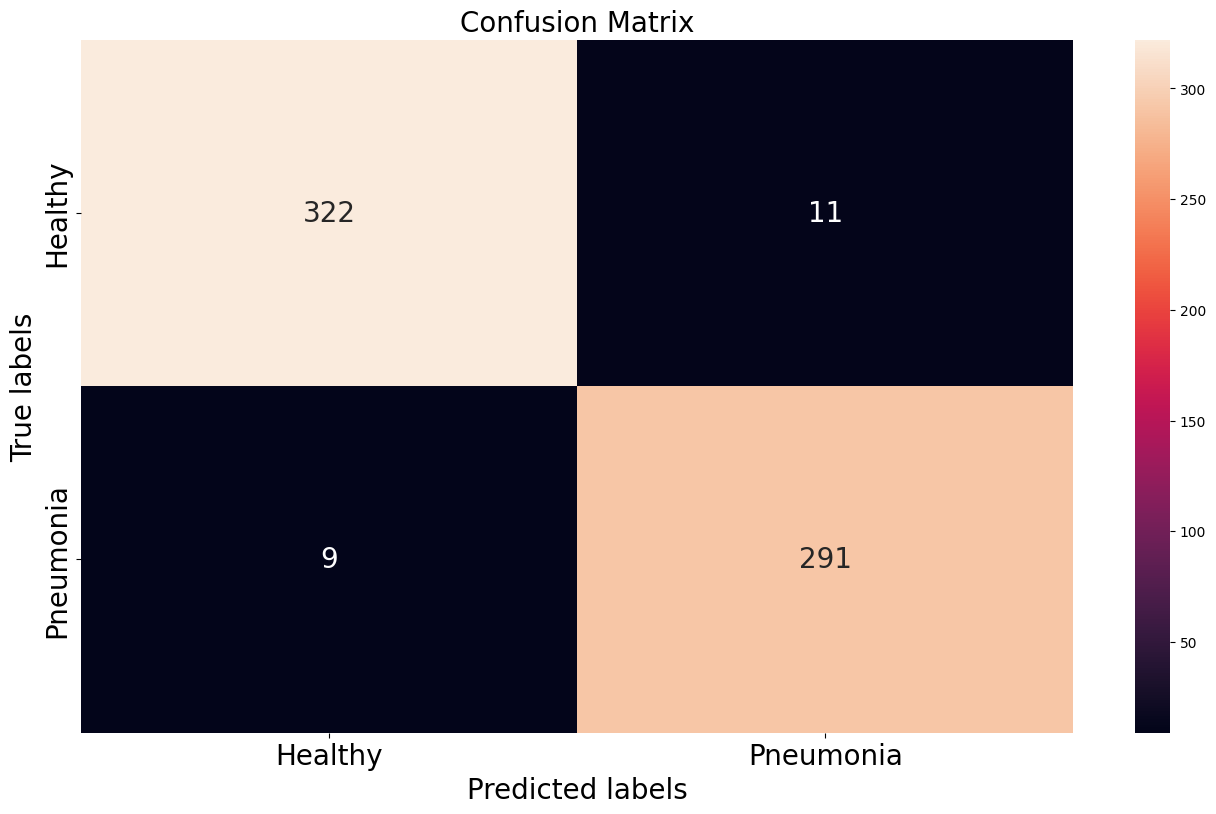

In [54]:
# a better confusion matrix
import seaborn as sns
# Apply threshold to outputs
outputs = np.array(outputs)
predicted = threshold(outputs, threshold=0.5)

# Generate confusion matrix
cm = confusion_matrix(y_true, predicted)

# Plot confusion matrix
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size":20})

# Labels, titles and ticks
ax.set_xlabel("Predicted labels", fontsize=20)
ax.set_ylabel("True labels", fontsize=20)
ax.set_title("Confusion Matrix", fontsize=20)
ax.xaxis.set_ticklabels(['Healthy', 'Pneumonia'], fontsize=20)
ax.yaxis.set_ticklabels(['Healthy', 'Pneumonia'], fontsize=20)

plt.show()